### Step-0: Import libraries

In [320]:
import numpy as np 
import pandas as pd 
import time
import math
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#Installing via pip
!pip install -U pandas-profiling
from pandas_profiling import ProfileReport

#ignore warnings.
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 

Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.9.0)


### Step-1: Load training and test datasets

In [2]:
from google.colab import files
files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


{'test.csv': b'Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition\n1461,20,RH,80,11622,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0,TA,TA

**1.1 Read datasets**

In [321]:
#read in data training and testing data.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

**1.2 View datasets**

In [322]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [323]:
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,CBlock,TA,TA,No,Rec,468.000,LwQ,144.000,270.000,882.000,GasA,TA,Y,SBrkr,896,0,0,896,0.000,0.000,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.000,Unf,1.000,730.000,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000,TA,TA,CBlock,TA,TA,No,ALQ,923.000,Unf,0.000,406.000,1329.000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000,0.000,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.000,Unf,1.000,312.000,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000,TA,TA,PConc,Gd,TA,No,GLQ,791.000,Unf,0.000,137.000,928.000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000,0.000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000,Fin,2.000,482.000,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000,TA,TA,PConc,TA,TA,No,GLQ,602.000,Unf,0.000,324.000,926.000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000,0.000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000,Fin,2.000,470.000,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000,Unf,0.000,1017.000,1280.000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000,0.000,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.000,RFn,2.000,506.000,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


**1.3 Data size & Priliminary data processing**

In [324]:
print("size of train data: {} ".format(train.shape))
print("size of test data: {} ".format(test.shape))

train_ID = train['Id']
test_ID = test['Id']

#Dropping Id column as not required for 'prediction'
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

print("\nsize of train data after dropping 'ID' : {} ".format(train.shape)) 
print("size of test data after dropping 'ID' : {} ".format(test.shape))

size of train data: (1460, 81) 
size of test data: (1459, 80) 

size of train data after dropping 'ID' : (1460, 80) 
size of test data after dropping 'ID' : (1459, 79) 


### Step-2: EDA

##### **2.1 Data profiling with Pandas**

In [ ]:
profile = ProfileReport(train, title='Training data - Profiling Report', explorative = True)
profile

##### **2.2 Understanding Features**

***2.2.1 Numerical features***

In [325]:
numerical_feats = train.dtypes[train.dtypes != "object"].index
print("Total continuous/numerical features: ", len(numerical_feats))
print("*"*70)
print(train[numerical_feats].columns)
print("*"*70)
train[numerical_feats].head()

Total continuous/numerical features:  37
**********************************************************************
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
**********************************************************************


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.000,8450,7,5,2003,2003,196.000,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.000,2,548,0,61,0,0,0,0,0,2,2008,208500
1,20,80.000,9600,6,8,1976,1976,0.000,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.000,2,460,298,0,0,0,0,0,0,5,2007,181500
2,60,68.000,11250,7,5,2001,2002,162.000,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.000,2,608,0,42,0,0,0,0,0,9,2008,223500
3,70,60.000,9550,7,5,1915,1970,0.000,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.000,3,642,0,35,272,0,0,0,0,2,2006,140000
4,60,84.000,14260,8,5,2000,2000,350.000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.000,3,836,192,84,0,0,0,0,0,12,2008,250000


***2.2.2 Categorical features***

In [326]:
categorical_feats = train.dtypes[train.dtypes == "object"].index
print("Total categorical features: ", len(categorical_feats))
print("*"*70)
print(train[categorical_feats].columns)
print("*"*70)
train[categorical_feats].head()

Total categorical features:  43
**********************************************************************
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
**********************************************************************


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


***2.2.3 List of categorical features and their values***

In [327]:
for catg in list(categorical_feats) :
    print(train[catg].value_counts())
    print('#'*50)

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64
##################################################
Pave    1454
Grvl       6
Name: Street, dtype: int64
##################################################
Grvl    50
Pave    41
Name: Alley, dtype: int64
##################################################
Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64
##################################################
Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64
##################################################
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
##################################################
Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64
##################################################
Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64
############################################

***2.2.4 Relation to SalePrice for all categorical features***

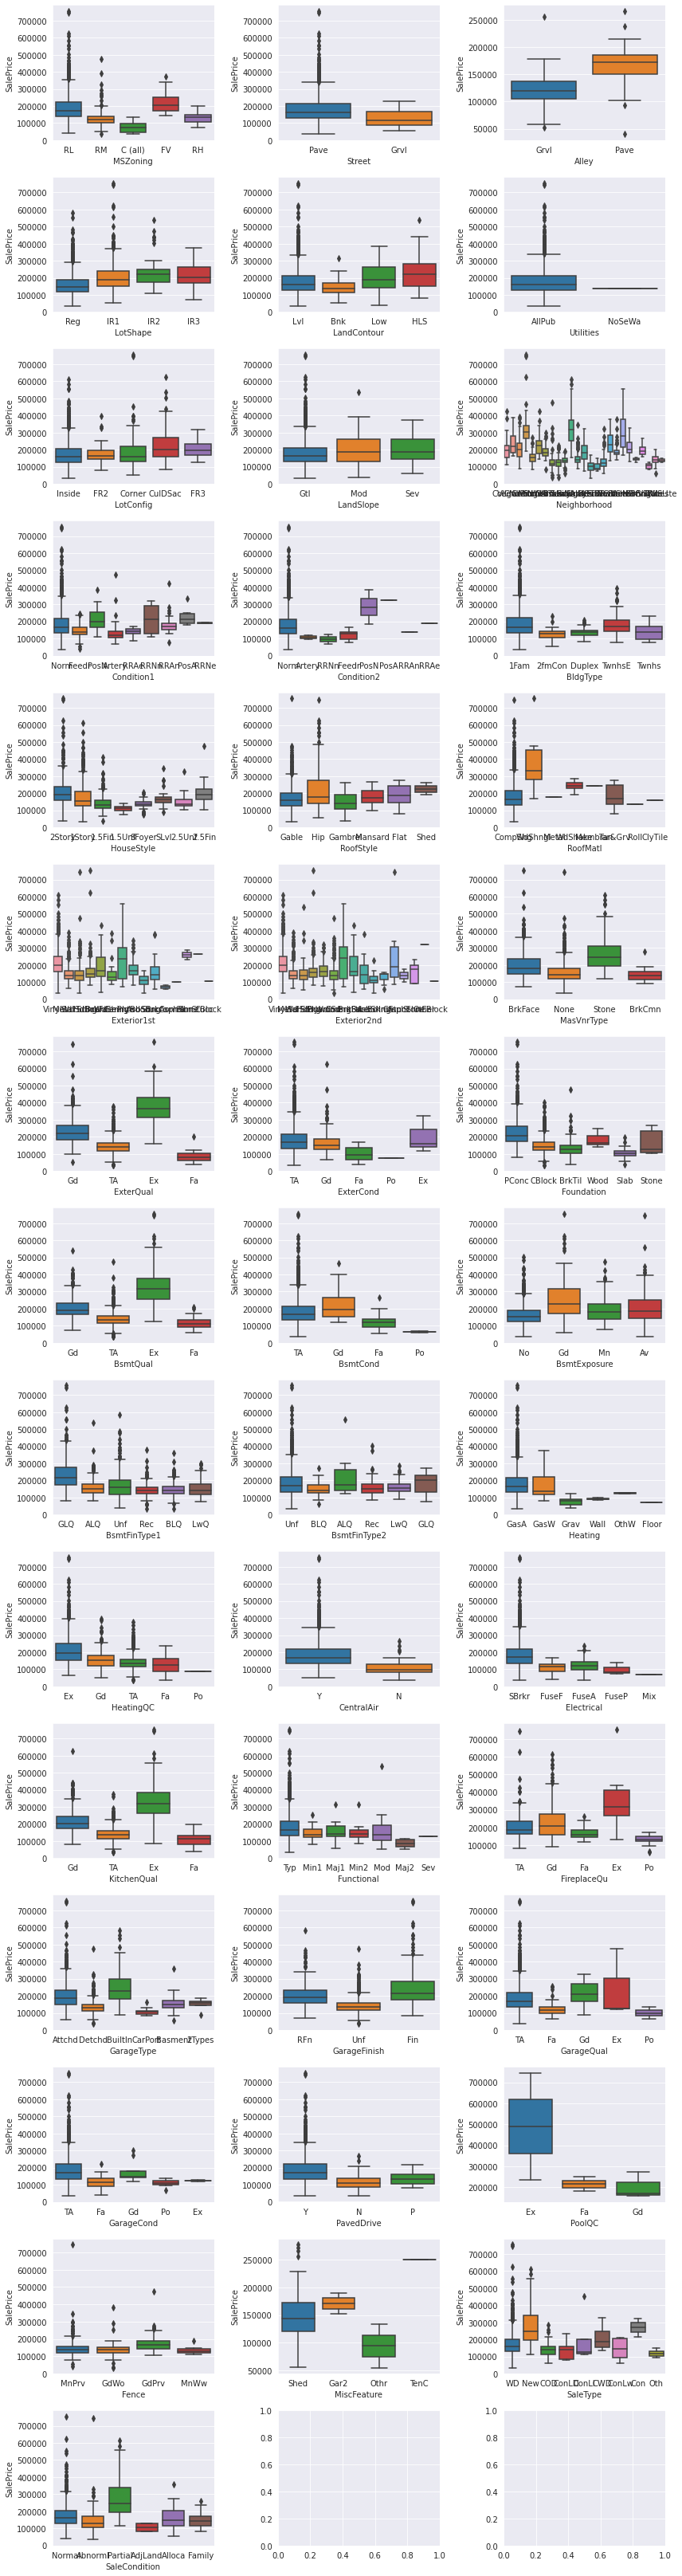

In [328]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

target = 'SalePrice'
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3))

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=train, ax = axs[r][c])
    
plt.tight_layout()    
plt.show()   

### Step-3: Preprocessing

##### **3.1 Remove Noise/ Outliers**

***3.1.1 Check for outlier/ Noise*** 

In [329]:
import plotly.express as px
import matplotlib.pyplot as plt  

d = {'GrLivArea': train['GrLivArea'], 'SalePrice': train['SalePrice']}
df = pd.DataFrame(data=d)

fig = px.scatter(df, x = 'GrLivArea', y = 'SalePrice', title='Total lot Area/ SalesPrice')
fig.show()

***3.1.2 Remove outliers*** 

In [330]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<200000)].index)

#Removing outliers which are big lots but still priced less.
d = {'GrLivArea': train['GrLivArea'], 'SalePrice': train['SalePrice']}
df = pd.DataFrame(data=d)

fig = px.scatter(df, x = 'GrLivArea', y = 'SalePrice', title='Total lot Area/ SalesPrice')
fig.show()

##### **3.2 Normalize target variables**

***3.2.1 Data distribution*** 

Skewness: 1.881296
Kurtosis: 6.523067


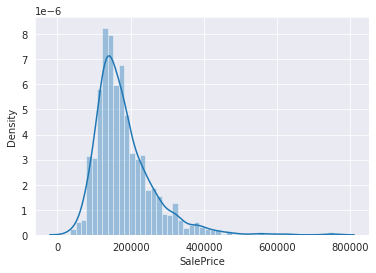

In [331]:
sns.distplot(train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

***3.2.1 Normalizing target*** 

Skewness: 0.121568
Kurtosis: 0.804764


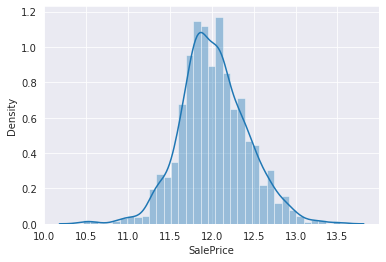

In [332]:
train['SalePrice'] = np.log(train['SalePrice'])
sns.distplot(train['SalePrice']);
# skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

#####***3.3 Handle Missing data***

***3.3.1 Identify missing data*** 

In [333]:
#training
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_train = pd.DataFrame({'(%) Missing' :train_na})
missing_train.head()

,(%) Missing
PoolQC,99.588
MiscFeature,96.296
Alley,93.759
Fence,80.727
FireplaceQu,47.325


In [334]:
#testing
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)[:30]
missing_test = pd.DataFrame({'(%) Missing' :test_na})
missing_test.head()

,(%) Missing
PoolQC,99.794
MiscFeature,96.504
Alley,92.666
Fence,80.123
FireplaceQu,50.034


***3.3.2 View missing data*** 

In [335]:
#Training
fig = px.bar(x=train_na.index, y=train_na)
fig.show()

In [336]:
#Testing
fig = px.bar(x=test_na.index, y=test_na)
fig.show()

***3.3.3 Impute missing data*** 

****Understing missing data by features****

From data description, meaning of 'No Value' for the below variables.

> **PoolQC** : No value refers to 'No Pool'.

> **MiscFeature** : No value refers to 'No misc feature'.

> **Alley** : No value refers to 'No alley access'.

> **Fence** : No value refers to 'No fence'.

> **FireplaceQu** : No value refers to 'No fireplace'.

> **GarageType, GarageFinish, GarageQual and GarageCond, GarageYrBlt, GarageArea and GarageCars**: No value refers to 'No garage information'.

> **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2**: No value refers to 'No basement information'.

> **MasVnrArea and MasVnrType**: No value refers to 'No Veneer'.

> **MSZoning (The general zoning classification)** :  replacing with mode 'RL' zone.

> **Utilities**: only 3 missing values. so, it is good to drop the future.

> **Electrical** : replacing with mode 'SBrkr'.

> **Functional** : No values refers to 'typ'

> **KitchenQual**: replacing with mode 'TA'.

> **SaleType** : replacing with mode 'WD'.

> **MSSubClass** : No value refers to 'No building class'.

> **LotFrontage** : imputing missing lot area with the mean of neighbouring houses square lot.

**Imputation strategy**

> Numerical missing values are imputed with '0'.

> Categorical missing values are imputed with 'None'.

> Few missing values are imputed with 'mode', 'median' instead of just uselessly setting it to 'None' or '0'


In [337]:
for col in ('MasVnrType','MSSubClass','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath','GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea'):
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)


train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])

test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])
test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])

#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.mean()))

test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.mean()))

train["Functional"] = train["Functional"].fillna("Typ")
test["Functional"] = test["Functional"].fillna("Typ")

**3.3.4 Check for missing data**

In [338]:
#Check remaining missing values if any 
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_train = pd.DataFrame({'Missing Ratio' :train_na})
missing_train.head()

,Missing Ratio


In [339]:
test_na = (test.isnull().sum() / len(test)) * 100
test_na = test_na.drop(test_na[test_na == 0].index).sort_values(ascending=False)
missing_test = pd.DataFrame({'Missing Ratio' :test_na})
missing_test.head()

#will drop Utilities in next step

,Missing Ratio
Utilities,0.137


We will drop Utilities in the next step

##### **3.4 Remove weakly correlated features**






***3.4.1 View original training correlation***

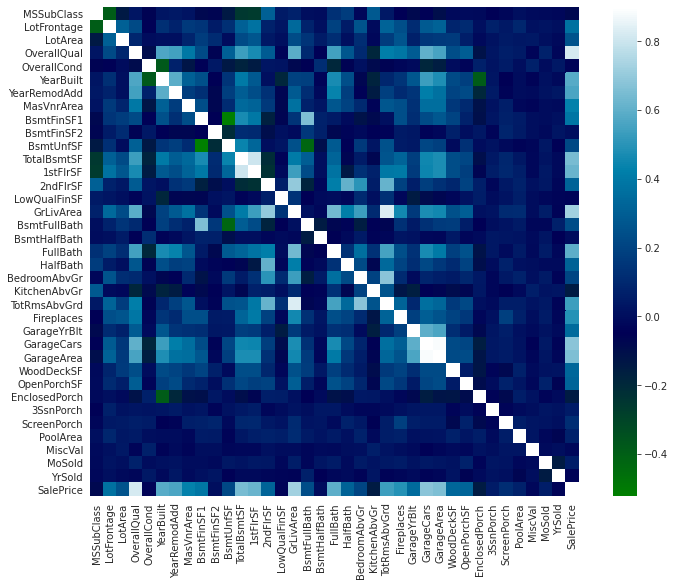

In [340]:
#Correlation map to see how training features are correlated with SalePrice

corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True, cmap='ocean')

***3.4.2 categorize features as strongly/ weakly correlated***

In [341]:
#(categories w/ strong and weak correlation determined based on E.D.A. tutorial in references)

catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition','Utilities']

***3.4.3 Remove weeakly correlated features***

In [342]:
#remove all categories with weak correlation
for cat in catg_weak_corr:
    if cat in train:
      del train[cat]
    if cat in test:
      del test[cat]
    
print(train.head())

   MSSubClass MSZoning  LotFrontage  ...  YrSold SaleType SalePrice
0          60       RL       65.000  ...    2008       WD    12.248
1          20       RL       80.000  ...    2007       WD    12.109
2          60       RL       68.000  ...    2008       WD    12.317
3          70       RL       60.000  ...    2006       WD    11.849
4          60       RL       84.000  ...    2008       WD    12.429

[5 rows x 47 columns]


***3.4.4 Group Correlation By Category***

In [343]:
#mean of SalePrice as a function of category, to intuit correlation
catg_list = catg_strong_corr.copy()
for catg in catg_list :
    g = train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)   11.118
FV        12.247
RH        11.750
RL        12.086
RM        11.693
Name: SalePrice, dtype: float64
Neighborhood
Blmngtn   12.169
Blueste   11.827
BrDale    11.548
BrkSide   11.680
ClearCr   12.240
CollgCr   12.164
Crawfor   12.207
Edwards   11.705
Gilbert   12.156
IDOTRR    11.447
MeadowV   11.475
Mitchel   11.934
NAmes     11.868
NPkVill   11.866
NWAmes    12.131
NoRidge   12.676
NridgHt   12.619
OldTown   11.704
SWISU     11.838
Sawyer    11.811
SawyerW   12.091
Somerst   12.296
StoneBr   12.585
Timber    12.363
Veenker   12.344
Name: SalePrice, dtype: float64
Condition2
Artery   11.570
Feedr    11.671
Norm     12.026
PosA     12.692
PosN     12.861
RRAe     12.155
RRAn     11.827
RRNn     11.435
Name: SalePrice, dtype: float64
MasVnrType
BrkCmn    11.853
BrkFace   12.164
None      11.897
Stone     12.431
Name: SalePrice, dtype: float64
ExterQual
Ex   12.792
Fa   11.305
Gd   12.311
TA   11.838
Name: SalePrice, dtype: float64
BsmtQual
Ex     12.650
Fa     11

***3.4.5 Correlations of features. to SalePrice***


In [344]:
corr_matrix = train.corr().abs()
print(corr_matrix[target].sort_values(ascending=False))

SalePrice       1.000
OverallQual     0.821
GrLivArea       0.725
GarageCars      0.681
GarageArea      0.656
TotalBsmtSF     0.648
1stFlrSF        0.620
FullBath        0.596
YearBuilt       0.587
YearRemodAdd    0.566
TotRmsAbvGrd    0.538
Fireplaces      0.492
MasVnrArea      0.431
BsmtFinSF1      0.392
LotFrontage     0.370
GarageYrBlt     0.349
WoodDeckSF      0.334
OpenPorchSF     0.325
2ndFlrSF        0.320
HalfBath        0.314
LotArea         0.261
BsmtFullBath    0.237
BsmtUnfSF       0.222
BedroomAbvGr    0.209
EnclosedPorch   0.149
KitchenAbvGr    0.148
ScreenPorch     0.121
PoolArea        0.074
MSSubClass      0.074
MoSold          0.057
3SsnPorch       0.055
LowQualFinSF    0.038
YrSold          0.037
OverallCond     0.037
MiscVal         0.020
BsmtHalfBath    0.005
BsmtFinSF2      0.005
Name: SalePrice, dtype: float64


***3.4.6 Drop features w/ low corelation to target***

In [345]:
for x in corr_matrix[target].sort_values(ascending=False).iteritems():
    if x[1] < 0.55:
        del train[x[0]]
        del test[x[0]]

In [346]:
corr_matrix = train.corr().abs()
print(corr_matrix[target].sort_values(ascending=False))

SalePrice      1.000
OverallQual    0.821
GrLivArea      0.725
GarageCars     0.681
GarageArea     0.656
TotalBsmtSF    0.648
1stFlrSF       0.620
FullBath       0.596
YearBuilt      0.587
YearRemodAdd   0.566
Name: SalePrice, dtype: float64


***3.4.7 Highly correlated features to target***

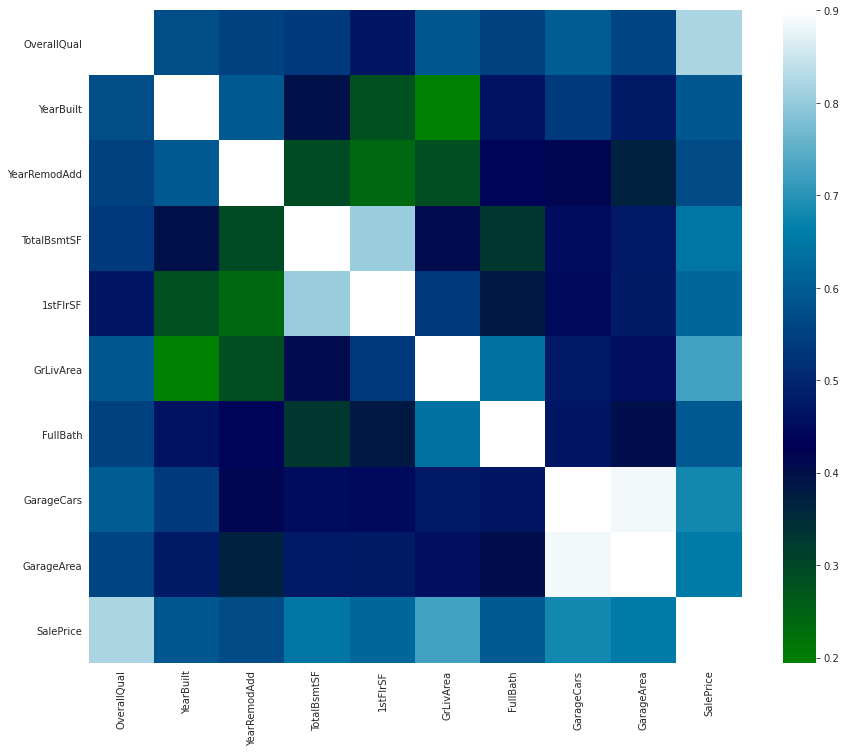

In [347]:
corr_matrix = train.corr().abs()
plt.subplots(figsize=(15,12))
sns.heatmap(corr_matrix, vmax=0.9, cmap="ocean", square=True)

Upon examining inter-feature correlation, it looks like all the features are highly correlated with at least one other feature.  This is a reason for eliminating a feature, but we can't drop all of them :)

##### **3.5 Data Encoding**


In [348]:
from sklearn.preprocessing import LabelEncoder
cols = [i for i in train.columns if train.dtypes[i]=='object']

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))
    
print('Shape all_train: {}'.format(train.shape))

cols = [i for i in test.columns if test.dtypes[i]=='object']

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(test[c].values)) 
    test[c] = lbl.transform(list(test[c].values))
    
print('Shape all_test: {}'.format(test.shape))

Shape all_train: (1458, 20)
Shape all_test: (1459, 19)


##### ***3.6 Adding new feature***

In [349]:
#Total square foot feature from the disparate square feet areas of the home that have significant correlation to target.
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] 
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] 

In [350]:
print(train)

      MSZoning  Neighborhood  Condition2  ...  SaleType  SalePrice  TotalSF
0            3             5           2  ...         8     12.248     1712
1            3            24           2  ...         8     12.109     2524
2            3             5           2  ...         8     12.317     1840
3            3             6           2  ...         8     11.849     1717
4            3            15           2  ...         8     12.429     2290
...        ...           ...         ...  ...       ...        ...      ...
1455         3             8           2  ...         8     12.073     1906
1456         3            14           2  ...         8     12.255     3615
1457         3             6           2  ...         8     12.493     2340
1458         3            12           2  ...         8     11.864     2156
1459         3             7           2  ...         8     11.902     2512

[1458 rows x 21 columns]


In [351]:
#move "SalePrice" target column to last column again

target_train = train.pop(target)

train.insert(20, target, target_train)

print(train.iloc[:,20])
print(train.head)

0      12.248
1      12.109
2      12.317
3      11.849
4      12.429
        ...  
1455   12.073
1456   12.255
1457   12.493
1458   11.864
1459   11.902
Name: SalePrice, Length: 1458, dtype: float64
<bound method NDFrame.head of       MSZoning  Neighborhood  Condition2  ...  SaleType  TotalSF  SalePrice
0            3             5           2  ...         8     1712     12.248
1            3            24           2  ...         8     2524     12.109
2            3             5           2  ...         8     1840     12.317
3            3             6           2  ...         8     1717     11.849
4            3            15           2  ...         8     2290     12.429
...        ...           ...         ...  ...       ...      ...        ...
1455         3             8           2  ...         8     1906     12.073
1456         3            14           2  ...         8     3615     12.255
1457         3             6           2  ...         8     2340     12.493
1458      

##### ***3.7 Scaling/ Removing undesired skewed/ Kurtosis***

***3.7.0 Using MaxAbsScaler Scaler***

In [352]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

X_train = train.iloc[:,:23].copy()
scaled_feat = scaler.fit_transform(X_train.values)
X_train = pd.DataFrame(scaled_feat, index=X_train.index, columns = X_train.columns)
X_train[target] = train[target].copy()
train = X_train.copy()

scaled_test = scaler.fit_transform(test)
test = pd.DataFrame(scaled_test, index=test.index, columns = test.columns)


***3.7.1 View skew/ kurtosis*** 

In [353]:
#for numerical statistics.
from scipy import stats
from scipy.stats import norm, skew 

#Saving targetPrice before normalizing
train1 = train.drop(['SalePrice'], 1)

numeric_feats = train1.iloc[:,:23].dtypes[train1.iloc[:,:23].dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = train1[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(30)


Skew in numerical features: 



,Skew
Condition2,13.676
GrLivArea,1.010
TotalSF,0.889
1stFlrSF,0.887
TotalBsmtSF,0.511
OverallQual,0.201
GarageArea,0.132
Neighborhood,0.039
FullBath,0.031
MasVnrType,-0.077


***3.7.2 Remove skew*** 

In [354]:
skewness = skewness[abs(skewness) > 0.099] #removing all negative skews which is undesired for prediction.
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    train[feat] = boxcox1p(train[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)

There are 20 skewed numerical features to Box Cox transform


In [355]:
train.shape

(1458, 21)

### Step-4: Data Preparation for Modeling

***4.1 Save preprocessed data***

In [356]:
train.to_csv('train_pp.csv')
test.to_csv('test_pp.csv')

print('Preprocessed data saved successfully!')

Preprocessed data saved successfully!


***4.2 Drop SalesPrice from train and store it for model evaluation***

In [357]:
targetPrice = np.asarray(train['SalePrice'])

train = train.drop(['SalePrice'], 1)

### Step-5: Model Analysis

#### ***5.1 Import model libraries***

In [358]:
from sklearn.model_selection import cross_val_score,RepeatedKFold,GridSearchCV

from sklearn.metrics import mean_squared_error,mean_squared_log_error
from sklearn.metrics import make_scorer

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
import xgboost as xgb
!pip install catboost
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans 
from scipy.spatial.distance import cdist 

from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import VotingRegressor
import time


#### ***5.2 Evaluation metric functions***

**Declare Model performance trackers**

In [359]:
r2Lst=[]
maeLst=[]
mseLst=[]
rmseLst = []
rmlseLst = []

models = []
train_time = []

In [360]:
from sklearn import metrics
def evalModel(y,y_pred,model):

  r2=metrics.r2_score(y,y_pred)
  mae=metrics.mean_absolute_error(y, y_pred)
  mse=metrics.mean_squared_error(y, y_pred)
  rmse=np.sqrt(metrics.mean_squared_error(y, y_pred))
  rmlse=np.sqrt(metrics.mean_squared_log_error(y, y_pred))

  models.append(model)  

  r2Lst.append(r2)
  maeLst.append(mae)
  mseLst.append(mse)
  rmseLst.append(rmse)
  rmlseLst.append(rmlse)

  print("R-Square Value",r2)
  print("\n")
  print ("mean_absolute_error :",mae)
  print("\n")
  print ("mean_squared_error : ",mse)
  print("\n")
  print ("root_mean_squared_error : ",rmse)
  print("\n")
  print ("root_mean_square_logarithmic_error : ",rmlse)

  #store prediction and target for generating accuracy reports.
  df = pd.DataFrame({'Actual':y,'Predicted':y_pred})
  df.to_csv(model+'.csv')


#### ***5.3 Machine Learning - Regression***

##### 5.3.0 **Cross validation settings**

In [361]:
n_folds = 5 

def rmsle_cv(model):
    # kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    kf = RepeatedKFold(n_splits=n_folds, n_repeats=3, random_state=1).get_n_splits(train.values)
    rmsle= np.sqrt(-cross_val_score(model, train.values, targetPrice, scoring="neg_mean_squared_error", cv = kf))
    return(rmsle)

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_log_error(y, y_pred))

##### 5.3.1 Technique: **Regularization**

###### 5.3.1.1 Model: **Ridge Regression**

In [362]:
start_time = time.time()

alpha_vals=[0.01, 0.2, 0.3, 0.4, 0.5]

model_ridge = RidgeCV(alphas=alpha_vals, normalize=True, cv=n_folds)

score = rmsle_cv(model_ridge)

print("(Ridge) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_ridge.fit(train, targetPrice)
ridge_train_pred = model_ridge.predict(train)

#metrics
evalModel(targetPrice, ridge_train_pred,'Ridge')

train_time.append(time.time()-start_time)

(Ridge) CV score: (Mean):0.1463, (Std):0.0127

R-Square Value 0.8702167105274958


mean_absolute_error : 0.10414720308064679


mean_squared_error :  0.02072156820285595


root_mean_squared_error :  0.14394988087128086


root_mean_square_logarithmic_error :  0.011201086693529462


###### 5.3.1.2 Model: **Lasso Regression**

In [363]:
start_time = time.time()

alpha_vals=[0.01, 0.2, 0.3, 0.4, 0.5]
model_lasso = LassoCV(alphas=alpha_vals, normalize=True, cv=n_folds)

score = rmsle_cv(model_lasso)

print("(Lasso) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_lasso.fit(train, targetPrice)
lasso_train_pred = model_lasso.predict(train)

evalModel(targetPrice, lasso_train_pred,'Lasso')

train_time.append(time.time()-start_time)

(Lasso) CV score: (Mean):0.3986, (Std):0.0305

R-Square Value 0.0


mean_absolute_error : 0.31013629872224463


mean_squared_error :  0.1596628370807785


root_mean_squared_error :  0.3995783240877544


root_mean_square_logarithmic_error :  0.03067352558515406


##### 5.3.2 Technique: **Boosting**

###### 5.3.2.1 Model: **XGBoost**

**Find best (hyper)parameter by tuning**

In [364]:
start_time = time.time()

model=xgb.XGBRegressor()

booster=['gbtree','gblinear']
learning_rate=[0.001,0.01,0.1,0.2,0.5]
n_estimators=[50,100,150,200,250,300]
max_depth=[2,4,6,8]
param_grid=dict(booster=booster,max_depth=max_depth,n_estimators=n_estimators,learning_rate=learning_rate)

random_search=RandomizedSearchCV(model,param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=n_folds)
result=random_search.fit(train,targetPrice)
print(result.best_estimator_)

[07:04:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [365]:
model_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=300,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

score = rmsle_cv(model_xgb)

print("(XGBoost) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_xgb.fit(train, targetPrice)
xgb_train_pred = model_xgb.predict(train)

evalModel(targetPrice, xgb_train_pred,'XGB')

train_time.append(time.time()-start_time)

(XGBoost) CV score: (Mean):0.1507, (Std):0.0227

R-Square Value 0.999272938495898


mean_absolute_error : 0.00710246079533383


mean_squared_error :  0.00011608470247713547


root_mean_squared_error :  0.010774261110495488


root_mean_square_logarithmic_error :  0.000835827236327576


###### 5.3.2.2 Model: **catBoost**

**Find best (hyper)parameter by tuning**

In [366]:
start_time = time.time()

param_grid = {'depth': [6,8,10],
                  'learning_rate': [0.01, 0.05, 0.1],
                  'iterations': [30, 50, 100,1000]
                 }
model_catb = CatBoostRegressor()
grid=RandomizedSearchCV(model_catb,param_grid,scoring='neg_mean_squared_log_error',n_jobs=-1,cv=n_folds)
result = grid.fit(train, targetPrice)
print(result.best_estimator_)

0:	learn: 0.3968181	total: 3.22ms	remaining: 3.21s
1:	learn: 0.3942638	total: 6.04ms	remaining: 3.02s
2:	learn: 0.3916956	total: 8.45ms	remaining: 2.81s
3:	learn: 0.3889685	total: 10.9ms	remaining: 2.71s
4:	learn: 0.3863540	total: 13.3ms	remaining: 2.64s
5:	learn: 0.3840739	total: 15.7ms	remaining: 2.59s
6:	learn: 0.3814913	total: 18ms	remaining: 2.56s
7:	learn: 0.3788993	total: 20.3ms	remaining: 2.52s
8:	learn: 0.3764790	total: 22.6ms	remaining: 2.49s
9:	learn: 0.3741828	total: 24.9ms	remaining: 2.46s
10:	learn: 0.3716619	total: 27.3ms	remaining: 2.46s
11:	learn: 0.3692395	total: 29.8ms	remaining: 2.46s
12:	learn: 0.3667919	total: 32.3ms	remaining: 2.45s
13:	learn: 0.3643537	total: 34.8ms	remaining: 2.45s
14:	learn: 0.3621513	total: 37.5ms	remaining: 2.46s
15:	learn: 0.3599957	total: 40ms	remaining: 2.46s
16:	learn: 0.3577489	total: 42.7ms	remaining: 2.47s
17:	learn: 0.3554261	total: 45.1ms	remaining: 2.46s
18:	learn: 0.3531180	total: 47.6ms	remaining: 2.46s
19:	learn: 0.3509684	total

In [367]:
model_catb = CatBoostRegressor(iterations=1000,
                          learning_rate=0.05,
                          depth=6)

score = rmsle_cv(model_catb)

print("(catBoost) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_catb.fit(train, targetPrice)
catb_train_pred = model_catb.predict(train)

evalModel(targetPrice, catb_train_pred,'CatBoost')

train_time.append(time.time()-start_time)

Streaming output truncated to the last 5000 lines.
15:	learn: 0.2536812	total: 38.5ms	remaining: 2.37s
16:	learn: 0.2471390	total: 40.8ms	remaining: 2.36s
17:	learn: 0.2411932	total: 43.1ms	remaining: 2.35s
18:	learn: 0.2358197	total: 45.3ms	remaining: 2.34s
19:	learn: 0.2306670	total: 47.4ms	remaining: 2.32s
20:	learn: 0.2257562	total: 49.7ms	remaining: 2.31s
21:	learn: 0.2209709	total: 52.2ms	remaining: 2.32s
22:	learn: 0.2167286	total: 53.8ms	remaining: 2.29s
23:	learn: 0.2124575	total: 56.6ms	remaining: 2.3s
24:	learn: 0.2083727	total: 59.1ms	remaining: 2.3s
25:	learn: 0.2046494	total: 61.5ms	remaining: 2.3s
26:	learn: 0.2009303	total: 64.1ms	remaining: 2.31s
27:	learn: 0.1977296	total: 66.6ms	remaining: 2.31s
28:	learn: 0.1944214	total: 69.1ms	remaining: 2.31s
29:	learn: 0.1910548	total: 71.6ms	remaining: 2.31s
30:	learn: 0.1881122	total: 74.2ms	remaining: 2.32s
31:	learn: 0.1852802	total: 76.5ms	remaining: 2.31s
32:	learn: 0.1825705	total: 80ms	remaining: 2.34s
33:	learn: 0.18007

##### 5.3.3 Technique: **Bagging Regressors**

###### 5.3.3.1 Model: **Random Forest Regressor**

**Find best (hyper)parameter by tuning**

In [368]:
start_time = time.time()

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
model_rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = RandomizedSearchCV(model_rf,param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=n_folds)
# Fit the grid search to the data
result = grid_search.fit(train, targetPrice)
print(result.best_estimator_)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)


In [369]:
model_rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=90, max_features=3, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

score = rmsle_cv(model_rf)
print("(Random Forest) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_rf.fit(train, targetPrice)
rf_train_pred = model_rf.predict(train)

evalModel(targetPrice, rf_train_pred,'Random Forest')

train_time.append(time.time()-start_time)

(Random Forest) CV score: (Mean):0.1500, (Std):0.0158

R-Square Value 0.9200480562254134


mean_absolute_error : 0.07648558636308644


mean_squared_error :  0.012765354173173375


root_mean_squared_error :  0.11298386687121915


root_mean_square_logarithmic_error :  0.008797141486013994


##### 5.3.4 Model: **Multi-Layer Neural Network**

**Find best (hyper)parameter by tuning**

In [370]:
start_time = time.time()
#NN 

#hyperparameter tuning

Y = pd.DataFrame(targetPrice)
Y.columns = ['SalePrice']
Y=Y.astype('int')

#default hidden layer size (1 layer with 100 neurons)

NN = MLPRegressor(activation= 'tanh', solver = 'lbfgs', alpha = 0.003, max_iter=1000,max_fun = 25000)
grid_param = {
    'max_fun': [25000, 30000]
}
NN = GridSearchCV(estimator=NN,
                     param_grid=grid_param,
                     scoring=make_scorer(rmsle, greater_is_better = False),
                     cv=n_folds,
                     n_jobs=-1)
grid_result = NN.fit(train, Y)
best_params = grid_result.best_params_
print(best_params)

{'max_fun': 30000}


In [371]:
model_NN = MLPRegressor(activation= 'tanh', solver = 'lbfgs', alpha = 0.003, max_iter=1000, max_fun = 25000)

score = rmsle_cv(model_NN)
print("(Multi-Layered Neural Network) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_NN.fit(train, targetPrice)
NN_train_pred = model_NN.predict(train)

evalModel(targetPrice, NN_train_pred,'Neural Network')

train_time.append(time.time()-start_time)

(Multi-Layered Neural Network) CV score: (Mean):0.1431, (Std):0.0193

R-Square Value 0.9129816458146836


mean_absolute_error : 0.08681960559108036


mean_squared_error :  0.013893597307327657


root_mean_squared_error :  0.1178711046326777


root_mean_square_logarithmic_error :  0.009129872612640805


##### 5.3.5 Technique: **SVM**

**Find best (hyper)parameter by tuning**

In [372]:
start_time = time.time()

# defining parameter range 
model_svm = svm.SVR()
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']}  
  
grid =RandomizedSearchCV(model_svm,param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=n_folds)

  
# fitting the model for grid search 
result = grid.fit(train, targetPrice) 
print(result.best_estimator_)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [373]:
folds = 5
seed = 7

model_label='svm-rbf'

# build model
model_svm = svm.SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

score = rmsle_cv(model_svm)

print("(SVM) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

# fit model
model_svm.fit(train, targetPrice)
svm_train_pred = model_svm.predict(train)

evalModel(targetPrice, svm_train_pred,'SVM')

train_time.append(time.time()-start_time)

(SVM) CV score: (Mean):0.1778, (Std):0.0146

R-Square Value 0.8082445673253749


mean_absolute_error : 0.12481278824360742


mean_squared_error :  0.03061621640648286


root_mean_squared_error :  0.17497490221881212


root_mean_square_logarithmic_error :  0.013607866531282353


##### **5.3.6 Technique: SGD**

In [374]:
start_time = time.time()

sgd_reg=SGDRegressor(penalty='l1',max_iter=10000,eta0=0.0001,alpha=0.0008,shuffle=True)

score = rmsle_cv(sgd_reg)

sgd_reg.fit(train, targetPrice)

sgd_train_pred = sgd_reg.predict(train)

evalModel(targetPrice, sgd_train_pred,'SGD')

train_time.append(time.time()-start_time)

R-Square Value -1.6699073548808219


mean_absolute_error : 0.5009107123376735


mean_squared_error :  0.4262849830231089


root_mean_squared_error :  0.6529050336941116


root_mean_square_logarithmic_error :  0.05208916060558725


##### 5.3.6 Technique: **Linear regression**

In [375]:
start_time = time.time()

model_linear = LinearRegression()
model_linear.fit(train, targetPrice)
linear_train_pred = model_linear.predict(train)

evalModel(targetPrice, linear_train_pred,'Linear')

train_time.append(time.time()-start_time)

R-Square Value 0.8702804344133652


mean_absolute_error : 0.10421868370764581


mean_squared_error :  0.020711393866448224


root_mean_squared_error :  0.14391453667523732


root_mean_square_logarithmic_error :  0.011198784838727167


##### 5.3.7 Technique: **KNN**

1 : 0.5489073709600955
2 : 0.4874005375599764
3 : 0.45884272018015354
4 : 0.43204054531626324
5 : 0.41140917938648686
6 : 0.39032355752204784
7 : 0.37787622541308336
8 : 0.36978180443375824
9 : 0.3616203168819072


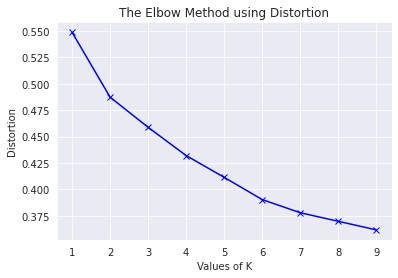

In [376]:
start_time = time.time()

X = train

distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

**Choosing 2-Neighbours as inferred from the 'elbow' curve**

In [377]:
from sklearn.neighbors import KNeighborsRegressor
model_knn= KNeighborsRegressor(n_neighbors=2)
model_knn.fit(train, targetPrice)

score = rmsle_cv(model_knn)

print("(KNN) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_knn.fit(train, targetPrice)
knn_train_pred = model_knn.predict(train)

evalModel(targetPrice, knn_train_pred,'KNN')

train_time.append(time.time()-start_time)

(KNN) CV score: (Mean):0.1946, (Std):0.0226

R-Square Value 0.923970956289026


mean_absolute_error : 0.07826767283988934


mean_squared_error :  0.012139012819432618


root_mean_squared_error :  0.11017718828973908


root_mean_square_logarithmic_error :  0.008530686646817774


##### 5.3.8 Technique: **Decision Tree**

**Find best (hyper)parameter by tuning**

In [378]:
start_time = time.time()

param_grid = {
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}
clf_tree=DecisionTreeRegressor()
grid =RandomizedSearchCV(clf_tree,param_grid,scoring='neg_mean_squared_error',n_jobs=-1,cv=n_folds)
# fitting the model for grid search 

result = grid.fit(train, targetPrice) 
print(result.best_params_)

{'min_samples_split': 12, 'min_samples_leaf': 5, 'max_features': 3, 'max_depth': 100}


In [379]:
#model_dt = DecisionTreeRegressor(max_depth=90,max_features=3,min_samples_leaf=4,min_samples_split=8)
model_dt = DecisionTreeRegressor()
score = rmsle_cv(model_dt)

print("(DT) CV score: (Mean):{:.4f}, (Std):{:.4f}\n".format(score.mean(), score.std()))

model_dt.fit(train, targetPrice)
dt_train_pred = model_dt.predict(train)

evalModel(targetPrice, dt_train_pred,'DT')

train_time.append(time.time()-start_time)

(DT) CV score: (Mean):0.1995, (Std):0.0196

R-Square Value 0.9998299248538379


mean_absolute_error : 0.0005254200645719024


mean_squared_error :  2.7154680353173255e-05


root_mean_squared_error :  0.005211015290053682


root_mean_square_logarithmic_error :  0.0004115095052583877


##### 5.3.9 Technique: **Choose best regressor as meta-regressor for stacking**

In [380]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'rmlse':rmlseLst})
data  = go.Data([
            go.Bar(
              y = df.rmlse,
              x = df.models
        )])
layout = go.Layout(title = "RMLSE for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

##### 5.3.10 Technique: **Voting Regressor**

In [381]:
start_time = time.time()

voted_reg = VotingRegressor([
              ('XGB', model_xgb),
              ('RIDGE',model_ridge), 
              ('LASSO',model_lasso), 
              ('CATB',model_catb),
              ('NN',model_NN), 
              ('SVM',model_svm), 
              ('SGD',sgd_reg),
              ('Linear',model_linear), 
              ('KNN',model_knn), 
              ('RF',model_rf),
              ('DT',model_dt)
              ])
vote= voted_reg.fit(train, targetPrice.ravel())
vote_pred=vote.predict(train)

evalModel(targetPrice, vote_pred,'Voting')

train_time.append(time.time()-start_time)

0:	learn: 0.3858546	total: 6.31ms	remaining: 6.31s
1:	learn: 0.3738919	total: 10.7ms	remaining: 5.34s
2:	learn: 0.3621268	total: 14.8ms	remaining: 4.92s
3:	learn: 0.3501905	total: 18.7ms	remaining: 4.66s
4:	learn: 0.3400862	total: 22.8ms	remaining: 4.54s
5:	learn: 0.3309873	total: 26.6ms	remaining: 4.4s
6:	learn: 0.3210252	total: 30.2ms	remaining: 4.29s
7:	learn: 0.3110881	total: 34.9ms	remaining: 4.33s
8:	learn: 0.3021369	total: 38.9ms	remaining: 4.28s
9:	learn: 0.2944050	total: 43.1ms	remaining: 4.27s
10:	learn: 0.2860470	total: 47.3ms	remaining: 4.25s
11:	learn: 0.2777859	total: 51.5ms	remaining: 4.24s
12:	learn: 0.2699987	total: 55.4ms	remaining: 4.21s
13:	learn: 0.2624727	total: 59.2ms	remaining: 4.17s
14:	learn: 0.2565426	total: 62.9ms	remaining: 4.13s
15:	learn: 0.2507880	total: 66.5ms	remaining: 4.09s
16:	learn: 0.2448396	total: 70.1ms	remaining: 4.06s
17:	learn: 0.2390893	total: 73.9ms	remaining: 4.03s
18:	learn: 0.2337019	total: 77.7ms	remaining: 4.01s
19:	learn: 0.2281769	to

##### 5.3.12 Technique: **StackingCV Regressor**

In [382]:
#use the best performing model as the meta regressor.
start_time = time.time()

model_stacked_reg = StackingCVRegressor(regressors=(voted_reg,model_xgb),
                                        meta_regressor=model_xgb,
                                        use_features_in_secondary=True)

grid = GridSearchCV(
    estimator=model_stacked_reg, 
    param_grid={
        'meta_regressor__n_estimators': [10, 100]
    }, 
    cv=n_folds,
    refit=True
)



grid.fit(np.array(train), np.array(targetPrice))
stacked_train_pred = grid.predict(np.array(train))

evalModel(targetPrice, stacked_train_pred,'Stacked')

train_time.append(time.time()-start_time)

Streaming output truncated to the last 5000 lines.
13:	learn: 0.2597750	total: 51.9ms	remaining: 3.65s
14:	learn: 0.2535609	total: 55.6ms	remaining: 3.65s
15:	learn: 0.2474793	total: 59.7ms	remaining: 3.67s
16:	learn: 0.2419172	total: 63.5ms	remaining: 3.67s
17:	learn: 0.2359599	total: 67.2ms	remaining: 3.66s
18:	learn: 0.2308816	total: 70.8ms	remaining: 3.65s
19:	learn: 0.2258178	total: 74.5ms	remaining: 3.65s
20:	learn: 0.2207610	total: 78.4ms	remaining: 3.66s
21:	learn: 0.2159986	total: 81.4ms	remaining: 3.62s
22:	learn: 0.2114814	total: 83.7ms	remaining: 3.56s
23:	learn: 0.2077935	total: 86ms	remaining: 3.5s
24:	learn: 0.2038576	total: 88.4ms	remaining: 3.45s
25:	learn: 0.2000080	total: 91.2ms	remaining: 3.42s
26:	learn: 0.1963426	total: 93.5ms	remaining: 3.37s
27:	learn: 0.1930998	total: 95.7ms	remaining: 3.32s
28:	learn: 0.1900077	total: 98.1ms	remaining: 3.28s
29:	learn: 0.1868421	total: 101ms	remaining: 3.25s
30:	learn: 0.1838049	total: 103ms	remaining: 3.22s
31:	learn: 0.18126

###### **Evaluating stacked regressor**

In [383]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'rmlse':rmlseLst})
data  = go.Data([
            go.Bar(
              y = df.rmlse,
              x = df.models
        )])
layout = go.Layout(title = "RMLSE for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

###### **Plotting stacked Regressors**

In [384]:
# def plot_stacked_regression(ax, targetPrice, predictedPrice, title, scores, elapsed_time):
#     ax.plot([targetPrice.min(), targetPrice.max()],
#             [targetPrice.min(), targetPrice.max()],
#             '--r', linewidth=2)
#     ax.scatter(targetPrice, predictedPrice, alpha=0.2)

#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.get_xaxis().tick_bottom()
#     ax.get_yaxis().tick_left()
#     ax.spines['left'].set_position(('outward', 10))
#     ax.spines['bottom'].set_position(('outward', 10))
#     ax.set_xlim([targetPrice.min(), targetPrice.max()])
#     ax.set_ylim([targetPrice.min(), targetPrice.max()])
#     ax.set_xlabel('targetPrice')
#     ax.set_ylabel('salePrice')
#     extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
#                           edgecolor='black', linewidth=0)
#     ax.legend([extra], [scores], loc='upper left')
#     title = title + 'n Computed in {:.2f} seconds'.format(elapsed_time)
#     ax.set_title(title)


# errors_list=[]
# estimators = [('Ridge', model_ridge),
#               ('Lasso', model_lasso),
#               ('CatBoost', model_catb),
#               ('Random Forest', model_rf),
#               ('SVM', model_svm),
#               ('SGD', sgd_reg),
#               ('Linear', model_linear),
#               ('KNN', model_knn),
#               ('XGB', model_xgb),
#               ('NN', model_NN)]

# trainCpy = train
# targetPriceCpy = targetPrice
# fig, axs = plt.subplots(5, 2, figsize=(20, 20))
# axs = np.ravel(axs)
# for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
#                                                model_stacked_reg)]):
#     start_time = time.time()
#     model = est.fit(np.array(trainCpy), np.array(targetPriceCpy))
                     
#     elapsed_time = time.time() - start_time
    
#     pred = model.predict(np.array(trainCpy))
#     errors = targetPriceCpy - pred
#     errors_list.append(errors)
#     test_r2= metrics.r2_score(np.exp(targetPriceCpy), np.exp(pred))
    
#     test_rmsle=math.sqrt(metrics.mean_squared_log_error(targetPriceCpy,pred))
#     plot_stacked_regression(ax,targetPriceCpy,pred,name,(r'$R^2={:.3f}$' + '\n' + 
#                             r'$RMSLE={:.3f}$').format(test_r2,test_rmsle),elapsed_time)
# plt.tight_layout()
# plt.subplots_adjust(top=0.9)
# plt.show()

##### 5.3.12 Technique: **Ensembling stacked regressor, best regressors**

In [385]:
def ensembling_blend_models(salePrice):
    return (
            (0.50 * model_xgb.predict(salePrice)) + \
            (0.15 * voted_reg.predict(salePrice)) + \
            (0.35 * grid.predict(np.array(salePrice))))

start_time = time.time()

ensembled_train_pred = ensembling_blend_models(train)
evalModel(targetPrice, ensembled_train_pred,'Ensembled')

train_time.append(time.time()-start_time)

R-Square Value 0.9854008313286552


mean_absolute_error : 0.03634038090383991


mean_squared_error :  0.0023309446890877306


root_mean_squared_error :  0.04827985800608501


root_mean_square_logarithmic_error :  0.003732546502167597


###### **Evaluating blended/ ensembled Regressors**

In [386]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'rmlse':rmlseLst})
data  = go.Data([
            go.Bar(
              y = df.rmlse,
              x = df.models
        )])
layout = go.Layout(title = "RMLSE for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

### Step-6: Visualize Model Performance

#### 6.0 Ensembled model predictions

In [387]:
import plotly.express as px

predictions = pd.DataFrame()
predictions['targetPrice'] = targetPrice
predictions['Predicted'] = ensembled_train_pred

df = px.data.tips()
fig = px.scatter(predictions, x="targetPrice", y="Predicted", trendline="ols",title='Ensembled Model Predictions')
fig.show()


#### 6.1: Root Mean Square Logarithmic Error

In [388]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'metric':rmlseLst})
data  = go.Data([
            go.Bar(
              y = df.metric,
              x = df.models
        )])
layout = go.Layout(title = "RMLSE for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

#### 6.2: Mean Absolute Error

In [389]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'metric':maeLst})
data  = go.Data([
            go.Bar(
              y = df.metric,
              x = df.models
        )])
layout = go.Layout(title = "MAE for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

#### 6.3: Mean Square Error

In [390]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'metric':mseLst})
data  = go.Data([
            go.Bar(
              y = df.metric,
              x = df.models
        )])
layout = go.Layout(title = "MSE for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

#### 6.4: Root Mean Square Error

In [391]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'metric':rmseLst})
data  = go.Data([
            go.Bar(
              y = df.metric,
              x = df.models
        )])
layout = go.Layout(title = "RMSE for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

#### 6.5: R2 Score

In [392]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'metric':r2Lst})
data  = go.Data([
            go.Bar(
              y = df.metric,
              x = df.models
        )])
layout = go.Layout(title = "R2 Score for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

#### 6.6: Training time

In [393]:
import plotly.graph_objects as go

df = pd.DataFrame({'models':models,'metric':train_time})
data  = go.Data([
            go.Bar(
              y = df.metric,
              x = df.models
        )])
layout = go.Layout(title = "Training time(secs) for different models"
)
fig  = go.Figure(data=data, layout=layout)
fig.show()

### Step-7: Using best Model for test data predictions

Ensembled model using stacked regressors, xgb, random forests has minimum regression error.


In [394]:
# Ensembled model using stacked regressors, xgb, random forests has minimum regression error.

ensembled_test_pred = np.expm1(ensembling_blend_models(test))

predictions = pd.DataFrame()
predictions['Id'] = test_ID
predictions['SalePrice'] = ensembled_test_pred
predictions.to_csv('HousePrice_Predictions.csv',index=False)

#### Best score on kaggle competition

> **Test Error (RMLSE):** 0.21932

### Step-8: Future Ideas/ Work

> To complete project report & presentation.

Outside Coursework,

> To finding Optimal Weights of Ensemble Learner using Neural Network/ available best approaches.

> Improve score on kaggle competition.

> Application focus:
  Real-time predictions using the ensembled model on a web platform.

> Deep-learning focus:
  Using similar dataset with house images for encompassing deep learning approaches towards estimating accurate value of the homes.

#References:

https://towardsdatascience.com/the-use-of-advanced-regression-techniques-for-home-value-prediction-c6ecb1f8fbfe


https://www.kaggle.com/carlolepelaars/understanding-the-metric-rmsle

https://towardsdatascience.com/a-guide-to-ensemble-learning-d3686c9bed9a

https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

https://machinelearningmastery.com/k-fold-cross-validation/

https://towardsdatascience.com/cross-validation-code-visualization-kind-of-fun-b9741baea1f8

https://medium.com/datadriveninvestor/random-forest-regression-9871bc9a25eb

https://machinelearningmastery.com/voting-ensembles-with-python/

https://towardsdatascience.com/11-evaluation-metrics-data-scientists-should-be-familiar-with-lessons-from-a-high-rank-kagglers-8596f75e58a7#5185

https://machinelearningmastery.com/k-fold-cross-validation/#:~:text=Cross%2Dvalidation%20is%20a%20resampling,k%2Dfold%20cross%2Dvalidation.

https://www.toptal.com/machine-learning/ensemble-methods-machine-learning
